### Using Factor Models to Estimate Pitcher Performance Based on Targeting Location

Estimate *latent factors* such as **pitch command** and **pitch effectiveness** that explain variation in observed outcomes. These factors may be influenced by the pitcher's targeted location.


Let $Y_i$ be a vector of observed pitch-level outcomes:

\begin{align*}
    Y_{i1}: Whiff \,\,(binary)\\
    Y_{i2}: ExitVelocity\,\, (continuous)\\
    Y_{i3}: Called Strike\,\, (binary)\\
    Y_{i4}: Run Value\,\, (numeric)
\end{align*}

***Latent Variables (Factors)***

Let the latent variables be: \$F_{i1}
$ (Pitch Command), $F_{i2}$ (Pitch Effectiveness)

Each observed variable is modeled as a function of latent variables:

\begin{align*}
    \text{Whiff}_i &= \lambda_1 F^{(effectiveness)}_i + \varepsilon_1 \\
    \text{ExitVelocity}_i &= \lambda_2 F^{(effectiveness)}_i + \varepsilon_2 \\
    \text{Strike}_i &= \lambda_3 F^{(command)}_i + \varepsilon_3
\end{align*}

Where:
\begin{align*}
     \lambda_j \,\,\,\text{are factor loadings} \\
     \varepsilon_j \,\,\,\text{are measurement errors}
\end{align*}

***Second Stage: Structural Model (Targeting Effects)***

We model the effect of pitch targeting location on the latent variables:

\begin{align*}
    F^{(command)}_i &= \beta_0 + \beta_1 \cdot \text{TargetLocation}_i + u_i \\
    F^{(effectiveness)}_i &= \gamma_0 + \gamma_1 \cdot \text{TargetLocation}_i + v_i
\end{align*}

***Evaluation and Interpretation***

\begin{align*}
    &\text{Factor Loadings} (\lambda):\,\,\, \text{How much each observed stat reflects the latent quality} \\
    &\text{Structural Coefficients} (\beta, \gamma): \text{Effect of location on latent traits} \\
    &\text{Fit Indices}: \text{RMSEA, CFI, TLI (for SEM implementations)}
\end{align*}

#### Dynamic Extension

For panel/time-series data (e.g., by game or inning), extend to a Dynamic Factor Model:

\begin{align*}
    F_t &= A F_{t-1} + \eta_t \\
    Y_t &= \Lambda F_t + \varepsilon_t
\end{align*}

Where:
\begin{align*}
    & F_t\,\,\, \text{is the vector of latent factors at time t}\\
    &A \,\,\, \text{is the transition matrix}\\
    &\Lambda \,\,\, \text{is the factor loading matrix}
\end{align*}


### Get the data (synthetic)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

# seed
np.random.seed(42)

# Generate synthetic data for 500 pitches
n = 500
target_location = np.random.uniform(low=0, high=1, size=n)  # 0 (poor location) to 1 (ideal)

# Simulate latent traits
pitch_command = 0.5 * target_location + np.random.normal(0, 0.2, size=n)
pitch_effectiveness = 0.7 * target_location + np.random.normal(0, 0.3, size=n)

# Simulate observed stats from latent traits
whiff_prob = 0.3 + 0.5 * pitch_effectiveness + np.random.normal(0, 0.1, size=n)
whiff = (whiff_prob > 0.5).astype(int)

exit_velocity = 90 - 5 * pitch_effectiveness + np.random.normal(0, 2, size=n)
strike_called = (pitch_command + np.random.normal(0, 0.1, size=n) > 0.5).astype(int)
run_value = -1 * pitch_effectiveness + np.random.normal(0, 0.2, size=n)

# Build DataFrame
df = pd.DataFrame({
    "TargetLocation": target_location,
    "Whiff": whiff,
    "ExitVelocity": exit_velocity,
    "StrikeCalled": strike_called,
    "RunValue": run_value
})


Matplotlib is building the font cache; this may take a moment.


### Plots

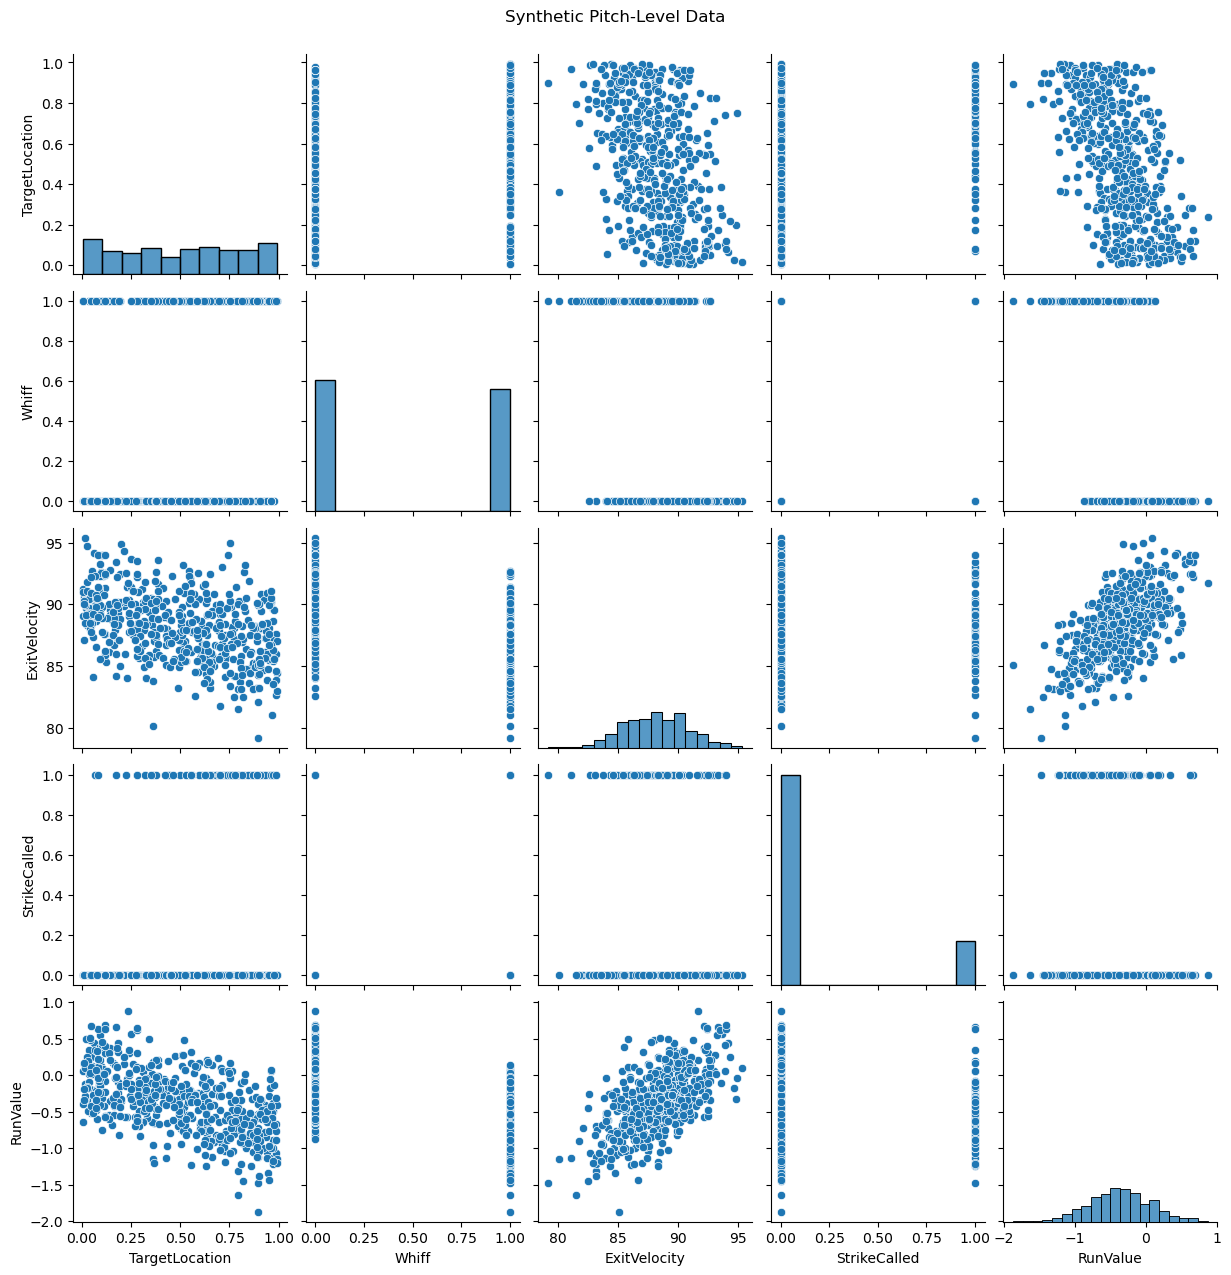

In [3]:
# Plot pairwise relationships
sns.pairplot(df)
plt.suptitle("Synthetic Pitch-Level Data", y=1.02)
plt.show()


### Estimate factors

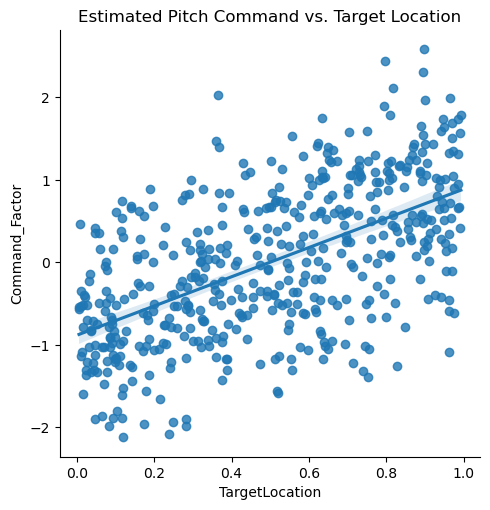

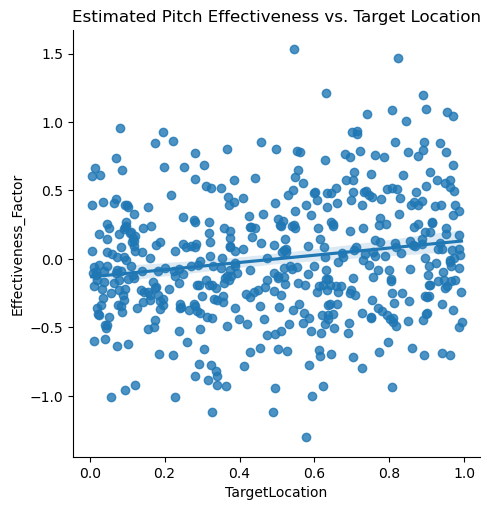

In [4]:
# Standardize variables
X = df[["Whiff", "ExitVelocity", "StrikeCalled", "RunValue"]]
X_scaled = StandardScaler().fit_transform(X)

# Run factor analysis 
fa = FactorAnalysis(n_components=2)
factors = fa.fit_transform(X_scaled)

# Add factors to dataframe
df['Command_Factor'] = factors[:, 0]
df['Effectiveness_Factor'] = factors[:, 1]

# Plot factor vs target location
sns.lmplot(data=df, x="TargetLocation", y="Command_Factor")
plt.title("Estimated Pitch Command vs. Target Location")

sns.lmplot(data=df, x="TargetLocation", y="Effectiveness_Factor")
plt.title("Estimated Pitch Effectiveness vs. Target Location")
plt.show()


### Explanation for non-technical audience

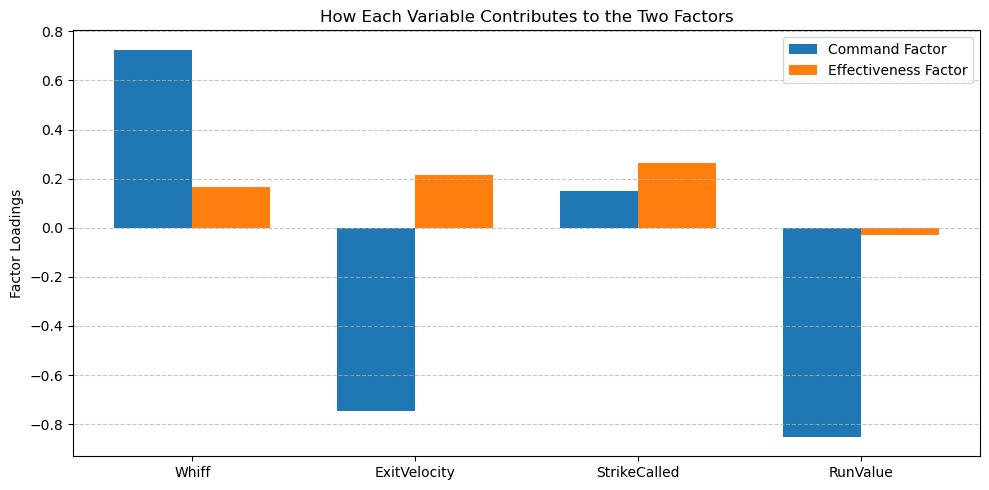

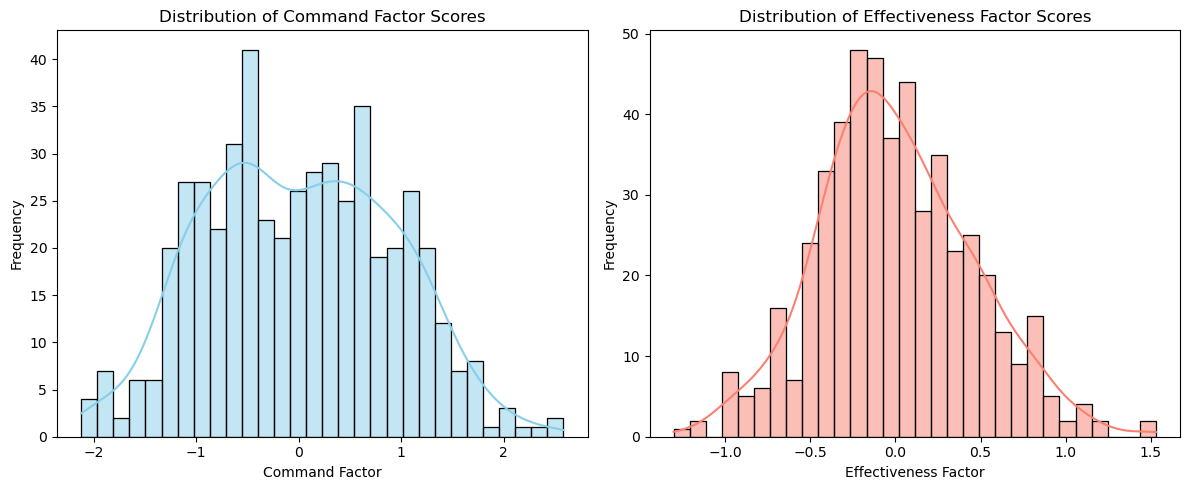

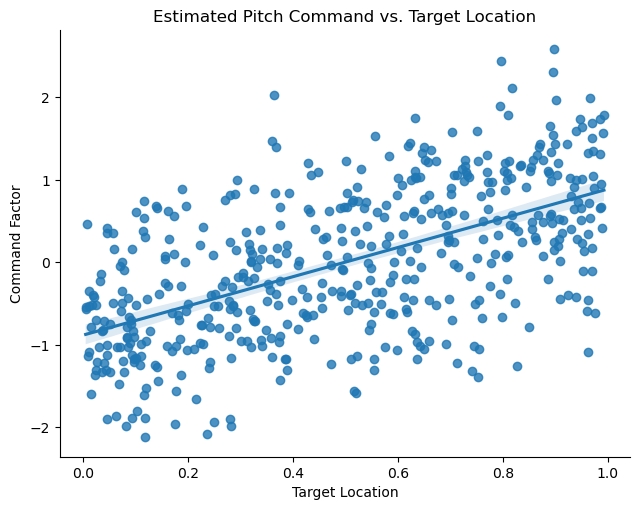

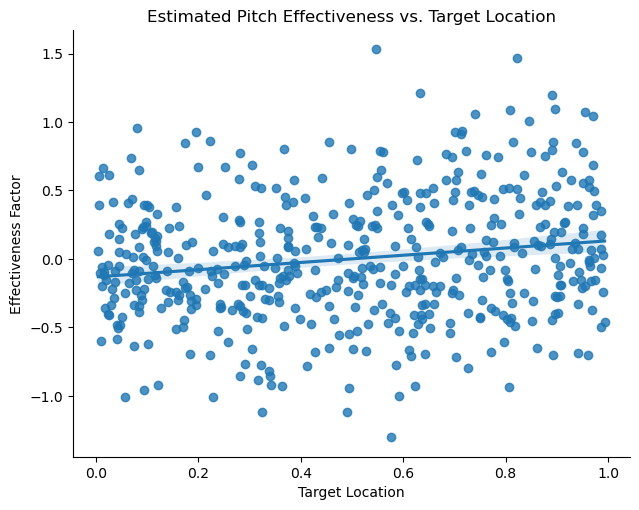

In [5]:
# Plot factor loadings: how original variables relate to each factor
loadings = fa.components_.T  # shape: variables x factors
variables = X.columns

plt.figure(figsize=(10,5))
bar_width = 0.35
indices = np.arange(len(variables))

plt.bar(indices - bar_width/2, loadings[:, 0], width=bar_width, label='Command Factor')
plt.bar(indices + bar_width/2, loadings[:, 1], width=bar_width, label='Effectiveness Factor')

plt.xticks(indices, variables)
plt.ylabel('Factor Loadings')
plt.title('How Each Variable Contributes to the Two Factors')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#  Plot distribution of factor scores 
fig, axs = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df['Command_Factor'], bins=30, kde=True, ax=axs[0], color='skyblue')
axs[0].set_title('Distribution of Command Factor Scores')
axs[0].set_xlabel('Command Factor')
axs[0].set_ylabel('Frequency')

sns.histplot(df['Effectiveness_Factor'], bins=30, kde=True, ax=axs[1], color='salmon')
axs[1].set_title('Distribution of Effectiveness Factor Scores')
axs[1].set_xlabel('Effectiveness Factor')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Scatterplots with regression lines of factors vs TargetLocation

sns.lmplot(data=df, x="TargetLocation", y="Command_Factor", height=5, aspect=1.3)
plt.title("Estimated Pitch Command vs. Target Location")
plt.xlabel("Target Location")
plt.ylabel("Command Factor")
plt.show()

sns.lmplot(data=df, x="TargetLocation", y="Effectiveness_Factor", height=5, aspect=1.3)
plt.title("Estimated Pitch Effectiveness vs. Target Location")
plt.xlabel("Target Location")
plt.ylabel("Effectiveness Factor")
plt.show()

#### When a pitcher targets the ball well inside the strike zone, they tend to have better command — throwing more strikes and fewer misses. However, the most effective pitches (leading to weak contact or outs) are often aimed at the edges of the strike zone, where batters struggle more. Our model quantifies this by showing Command correlates strongly with strike control stats, while Effectiveness correlates with how hard batters can hit the ball and how many runs are prevented. By adjusting their target location, pitchers can balance between precise control and maximum effectiveness

